In [220]:
from IPython.display import display
import sys
import numpy as np
import pandas as pd
import os
from ebmdatalab import bq
import datetime
import plotly.express as px
import plotly.io as pio
from IPython.display import Markdown
import warnings
import requests
warnings.filterwarnings('ignore')
pio.templates.default = "plotly_white"
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
import scipy.stats as stats
register_matplotlib_converters()
from statsforecast import StatsForecast

from statsforecast.models import ARIMA
from time import time
import seaborn as sns
sns.set(style="whitegrid")
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
import warnings
warnings.filterwarnings('ignore')
import time

RANDOM_SEED = np.random.seed(0)

In [415]:

%run forecasting.py

# Prototyping ARIMA forecasting for primary care prescribing data

Some stuff here about terrible forecasting.

## Set test modelling parameters before starting

In [335]:
start_data = '2021-04-01'
end_data = '2024-03-01'

# Define the top x% you want to identify
top_x_percent = 90 


## Define any needed functions

### Step 1: Get price data

#### Step 1a: obtain Drug Tariff and price concession data

In [299]:
# define SQL for getting dt data from BigQuery
# this gets dt data, and substitutes price concession data where it exists for a VMPP and date.  It only gets data between the start data and end forecast variables defined above.

sql = f""" 
SELECT
  dt.date AS month,
  dt.vmpp AS vmpp,
  vmpp.bnf_code AS bnf_code,
  dt.price_pence AS price_pence,
  pc.price_pence AS pc_price_pence,
  vmpp.qtyval AS qtyval
FROM
  dmd.tariffprice AS dt
INNER JOIN
  dmd.vmpp AS vmpp
ON
  dt.vmpp = vmpp.id
LEFT OUTER JOIN
  dmd.ncsoconcession AS pc
ON
  dt.vmpp = pc.vmpp
  AND dt.date = pc.date
WHERE
  dt.date BETWEEN '{start_data}' AND '{end_data}'
"""
exportfile = os.path.join("..","data","dt_price_df.csv") # defines name for cache file
dt_raw_df = bq.cached_read(sql, csv_path=exportfile, use_cache=False) # uses BQ if changed, otherwise csv cache file
dt_raw_df['price_per_unit'] = dt_raw_df['price_pence']/dt_raw_df['qtyval'] # create price per unit column for dt data
dt_raw_df['pc_price_per_unit'] = dt_raw_df['pc_price_pence']/dt_raw_df['qtyval'] # create price per unit column for dt data
dt_raw_df['month'] = pd.to_datetime(dt_raw_df['month']) # ensure month data is datetime format

Downloading: 100%|█████████████████████████████████████████████████████████████|


In [300]:
dt_price_df = rank_and_filter_prices(dt_raw_df) #use function create ranking of price per unit for each BNF code (as possibly multiple VMPPs per BNF code), and create filtered df containing only the top ranked one

#### Step 1b: obtain other drug costs

In [450]:
# define SQL for getting dt data from BigQuery
# this gets dm+d data, where there is an NHS indicative price listed
sql = """
SELECT
  ampp.id AS ampp,
  ampp.bnf_code,
  priceinfo_price,
  priceinfo_pricedt,
  priceinfo_price_prev,
  CASE WHEN qty_uom = 'dose' THEN 1 ELSE qtyval END AS qtyval
FROM
  `ebmdatalab.dmd.ampp_full` AS ampp
INNER JOIN
  dmd.vmpp_full AS vmpp
ON
  ampp.vmpp = vmpp.id
WHERE
  priceinfo_price_basis = 'NHS Indicative Price'
"""
exportfile = os.path.join("..","data","dmd_raw_df.csv") # defines name for cache file
dmd_raw_df = bq.cached_read(sql, csv_path=exportfile, use_cache=False) # uses BQ if changed, otherwise csv cache file
dmd_raw_df['priceinfo_pricedt'] = pd.to_datetime(dmd_raw_df['priceinfo_pricedt']) # convert priceinfo_pricedt to datetime

Downloading: 100%|█████████████████████████████████████████████████████████████|


In [451]:
##SORT DATE VARIABLES###

dmd_price_df = process_dmd_data(dmd_raw_df, '2023-04-01', '2024-03-01') #use function to process dm+d data into a df with month and bnf_code data, only having one row for each bnf_code and month

In [452]:
dmd_price_df.head(20)

,month,bnf_code,price_per_unit
33137,2023-04-01,0101010F0BCAAAU,307.3333333333333333333333333
118086,2023-05-01,0101010F0BCAAAU,307.3333333333333333333333333
203035,2023-06-01,0101010F0BCAAAU,307.3333333333333333333333333
287984,2023-07-01,0101010F0BCAAAU,307.3333333333333333333333333
372933,2023-08-01,0101010F0BCAAAU,307.3333333333333333333333333
457882,2023-09-01,0101010F0BCAAAU,307.3333333333333333333333333
542831,2023-10-01,0101010F0BCAAAU,307.3333333333333333333333333
627780,2023-11-01,0101010F0BCAAAU,307.3333333333333333333333333
712729,2023-12-01,0101010F0BCAAAU,307.3333333333333333333333333
797678,2024-01-01,0101010F0BCAAAU,307.3333333333333333333333333


#### Step 1c: merge data into single dataframe

In [453]:
full_price_df = merge_and_update_prices(dmd_price_df, dt_price_df) # use function to merge dm+d codes (which are not already included in dt) into dt df to create single list of prices

####### TEST REMOVE #########

#exportfile = os.path.join("..","data","full_price_df.csv") # defines name for cache file
#full_price_df.to_csv(exportfile, index=False)

### Step 2: get prescribing data

In [305]:
sql = f"""
SELECT DATE(month) AS month,
       bnf_name,
       bnf_code,
       SUM(quantity) AS quantity,
       SUM(items) AS items,
       SUM(actual_cost) AS actual_cost
FROM   hscic.normalised_prescribing 
WHERE  month BETWEEN '{start_data}' AND '{end_data}'
GROUP BY month,
          bnf_code,
          bnf_name 
"""

exportfile = os.path.join("..","data","rx_df.csv") #defines name for cache file
rx_df = bq.cached_read(sql, csv_path=exportfile, use_cache=True) #uses BQ if changed, otherwise csv cache file
rx_df['month'] = pd.to_datetime(rx_df['month']) #ensure dates are in datetimeformat

### Step 3: work out the top X percent of items and cost for BNF codes

In [454]:
topx_rx_df, non_topx_rx_df, top_bnf_codes = filter_top_bnf_codes(rx_df, top_x_percent) # uses function to create separate dataframes for presentations with item or cost either in or not in top_x_percent

Number of BNF codes in top 90% items or spend: 2674


### Step 4: create dataframe for use with ARIMA forecasting tool

In [421]:
# create df for use with statsforecast, having only neccesary columns and named correctly
arima_df = topx_rx_df[['month', 'bnf_code', 'quantity']].copy()

# Rename columns to fit statsforecast
arima_df.rename(columns={
    'month': 'ds',
    'bnf_code': 'unique_id',
    'quantity': 'y'
}, inplace=True)

### Step 5: Create dataframe and variables for testing at various points in financial year

In [422]:
# set variables for test modelling
latest_data = pd.to_datetime('2023-09-01') # test month for last data available - allows us to model throughout the year
latest_pricing_data = pd.to_datetime(latest_data  + pd.DateOffset(months=2)) # assume that pricing data is usually two months ahead of prescribing data for testing purposes

# create test df for testing fit models
test_arima_df = arima_df[(arima_df['ds'] >= start_data) & (arima_df['ds'] <= latest_data)].sort_values(by=['ds','unique_id']) # creates testing model of prescribing data with modelling for various points in the year

In [347]:
print(test_arima_df['unique_id'].nunique())

2674


### Step 6: Create ARIMA forecasting model and undertake forecasting for top x BNF codes

In [352]:
# create statsforecast model
season_length = 12 # Monthly data 
horizon = (pd.to_datetime(end_forecast).year - latest_data.year) * 12 + (pd.to_datetime(end_forecast).month - latest_data.month) # calculates the number of months needed in the prediction, depending on number of months of in year data avaialble
models = [AutoARIMA(season_length=season_length)] # set AutoARIMA as model
sf = StatsForecast(df=test_arima_df,
                   models=models,
                   freq='MS', #frequency start of month
                   n_jobs=-1) # use all processors

start_time = time.time()
forecast_rx_df = sf.forecast(horizon, fitted=True, level=[95])

forecast_rx_df.reset_index()
end_time = time.time()
# Print the start and end times, and the elapsed time
print(f"Start Time: {start_time_readable}")
print(f"End Time: {end_time_readable}")

Start Time: 2024-08-24 12:26:30
End Time: 2024-08-24 12:29:08


In [423]:
forecast_rx_df.reset_index()


,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,0101012B0AAABAB,2023-10-01,283286.031250,236661.203125,329910.812500
1,0101012B0AAABAB,2023-11-01,283286.031250,224847.062500,341724.968750
2,0101012B0AAABAB,2023-12-01,283286.000000,215048.546875,351523.468750
3,0101012B0AAABAB,2024-01-01,283286.000000,206490.250000,360081.781250
4,0101012B0AAABAB,2024-02-01,283286.000000,198794.421875,367777.593750
...,...,...,...,...,...
16039,23961009685,2023-11-01,9511.044922,8319.670898,10702.419922
16040,23961009685,2023-12-01,9396.026367,7996.155762,10795.896484
16041,23961009685,2024-01-01,9414.151367,7936.741211,10891.561523
16042,23961009685,2024-02-01,9435.267578,7876.438477,10994.096680


In [358]:
print(forecast_rx_df['unique_id'].nunique())

KeyError: 'unique_id'

In [456]:
plot_df = pd.merge(topx_rx_df, forecast_rx_df, left_on=['month', 'bnf_code'], right_on=['ds','unique_id'], how='outer').sort_values(by=['month'])

In [457]:
test_full_price_df = full_price_df[
    (full_price_df['month'] <= latest_pricing_data) &
    (full_price_df['bnf_code'].isin(top_bnf_codes))
]

In [458]:
print(test_full_price_df)

            month         bnf_code  price_per_unit  pc_price_per_unit
36     2021-04-01  0402010U0AAAEAE       33.926667                NaN
37     2021-05-01  0402010U0AAAEAE       33.926667                NaN
38     2021-06-01  0402010U0AAAEAE       33.926667                NaN
39     2021-07-01  0402010U0AAAEAE       33.926667                NaN
40     2021-08-01  0402010U0AAAEAE       33.926667                NaN
...           ...              ...             ...                ...
435486 2023-07-01      23961009685      641.200000                NaN
435487 2023-08-01      23961009685      641.200000                NaN
435488 2023-09-01      23961009685      641.200000                NaN
435489 2023-10-01      23961009685      641.200000                NaN
435490 2023-11-01      23961009685      641.200000                NaN

[52789 rows x 4 columns]


In [315]:
start_time=time.time()
final_df = fill_missing_dates(test_full_price_df, end_forecast)
end_time=time.time()
print_time_summary(start_time, end_time)

Start Time: 2024-08-24 16:37:04
End Time: 2024-08-24 16:37:18
Elapsed Time: 13.72 seconds


In [459]:
start_time=time.time()
final_df = fill_missing_dates_opt(test_full_price_df, end_forecast)
end_time=time.time()
print_time_summary(start_time, end_time)

Start Time: 2024-08-24 20:22:08
End Time: 2024-08-24 20:22:08
Elapsed Time: 0.10 seconds


In [460]:
costed_plot_df = pd.merge(plot_df, final_df, on=['month', 'bnf_code'], how='left') # merge to get prices
costed_plot_df['price_per_unit'] = costed_plot_df['price_per_unit'].astype(float)
costed_plot_df['pc_price_per_unit'] = costed_plot_df['pc_price_per_unit'].astype(float)

In [461]:
costed_plot_df.head()

,month,bnf_name,bnf_code,quantity,items,actual_cost,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,price_per_unit,pc_price_per_unit
0,2021-04-01,Sodium bicarbonate 420mg/5ml (1mol/ml) soln su...,0101012B0AAABAB,296092.0,459.0,108835.11558,NaT,NaN,NaN,NaN,39.840000,NaN
1,2021-04-01,Colecalciferol 880unit / Calcium carbonate 2.5...,0906040G0AADIDI,322241.0,11054.0,30322.72910,NaT,NaN,NaN,NaN,9.833333,NaN
2,2021-04-01,"Colecalciferol 20,000unit capsules",0906040G0AADRDR,253893.0,23435.0,246855.73332,NaT,NaN,NaN,NaN,113.600000,NaN
3,2021-04-01,Colecalciferol 400unit tablets,0906040G0AAELEL,293044.0,7752.0,44859.50960,NaT,NaN,NaN,NaN,NaN,NaN
4,2021-04-01,Accrete D3 tablets,0906040G0BKAABS,6786996.0,128939.0,321552.52487,NaT,NaN,NaN,NaN,NaN,NaN


In [462]:
print(costed_plot_df['bnf_code'].nunique())

2674


In [463]:
#calculate ppu arima costings

costed_plot_df['predicted_cost'] = costed_plot_df['AutoARIMA'] * (costed_plot_df['pc_price_per_unit'].fillna(.9367*costed_plot_df['price_per_unit']))/100
costed_plot_df['predicted_cost_AutoARIMA-lo-95'] = costed_plot_df['AutoARIMA-lo-95'] * (costed_plot_df['pc_price_per_unit'].fillna(.9367*costed_plot_df['price_per_unit']))/100
costed_plot_df['predicted_cost_AutoARIMA-hi-95'] = costed_plot_df['AutoARIMA-hi-95'] * (costed_plot_df['pc_price_per_unit'].fillna(.9367*costed_plot_df['price_per_unit']))/100


In [ ]:
#costed_plot_df = pd.merge(topx_rx_df, Y_hat_df, left_on=['month', 'bnf_code'], right_on=['ds','unique_id'], how='outer').sort_values(by=['month'])

#plot_df = plot_df.sort_values(by=['ds'])
# Iterate through each unique bnf_code

for code in costed_plot_df['bnf_code'].unique():
    # Filter the DataFrame for the current bnf_code
    filtered_df = costed_plot_df[costed_plot_df['bnf_code'] == code]
    
    # Get the corresponding bnf_name (assuming it's the same for the given bnf_code)
    #bnf_name = filtered_df['bnf_name'].iloc[0]
    
    # Plot month vs items
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df['month'], filtered_df['actual_cost'])
    plt.plot(filtered_df['month'], filtered_df['predicted_cost'])
    
    # Set the title to the bnf_name
    #plt.title(bnf_name)
    plt.ylim(bottom=0)
    
    # Label the axes
    plt.xlabel('Month')
    plt.ylabel('Cost')
    
    # Show the plot
    plt.show()

In [464]:
costed_plot_df.head()

,month,bnf_name,bnf_code,quantity,items,actual_cost,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,price_per_unit,pc_price_per_unit,predicted_cost,predicted_cost_AutoARIMA-lo-95,predicted_cost_AutoARIMA-hi-95
0,2021-04-01,Sodium bicarbonate 420mg/5ml (1mol/ml) soln su...,0101012B0AAABAB,296092.0,459.0,108835.11558,NaT,NaN,NaN,NaN,39.840000,NaN,NaN,NaN,NaN
1,2021-04-01,Colecalciferol 880unit / Calcium carbonate 2.5...,0906040G0AADIDI,322241.0,11054.0,30322.72910,NaT,NaN,NaN,NaN,9.833333,NaN,NaN,NaN,NaN
2,2021-04-01,"Colecalciferol 20,000unit capsules",0906040G0AADRDR,253893.0,23435.0,246855.73332,NaT,NaN,NaN,NaN,113.600000,NaN,NaN,NaN,NaN
3,2021-04-01,Colecalciferol 400unit tablets,0906040G0AAELEL,293044.0,7752.0,44859.50960,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-04-01,Accrete D3 tablets,0906040G0BKAABS,6786996.0,128939.0,321552.52487,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [433]:
grouped_df = costed_plot_df.groupby('month')[['actual_cost', 'predicted_cost', 'predicted_cost_AutoARIMA-lo-95', 'predicted_cost_AutoARIMA-hi-95']].sum().reset_index()
grouped_df.replace(0, np.nan, inplace=True)

In [471]:
fil_costed_plot_df = costed_plot_df[
    (costed_plot_df['month'] >= '2023-04-01')]

In [472]:
fil_grouped_bnf_df = fil_costed_plot_df.groupby('bnf_code')[['actual_cost', 'predicted_cost', 'predicted_cost_AutoARIMA-lo-95', 'predicted_cost_AutoARIMA-hi-95']].sum().reset_index()

In [473]:
fil_grouped_bnf_df.head(50)
# Define the file name
file_name = 'fil_grouped_bnf_df.csv'

# Save DataFrame to CSV
fil_grouped_bnf_df.to_csv(file_name, index=False)

In [384]:
fil_full_price_df = full_price_df[
    (full_price_df['bnf_code'] == '0302000C0BQAABX')]

In [385]:
fil_full_price_df.head()

,month,bnf_code,price_per_unit,pc_price_per_unit


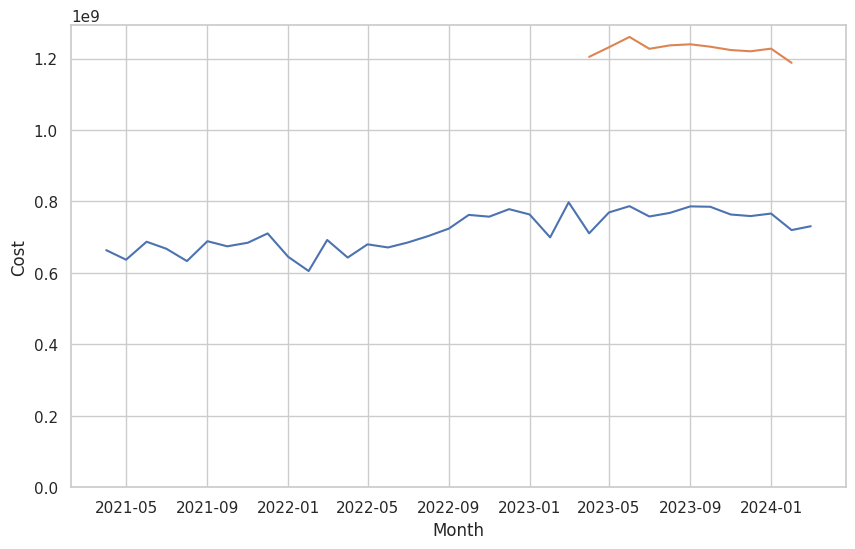

In [465]:
 # Plot month vs items
plt.figure(figsize=(10, 6))
plt.plot(grouped_df['month'], grouped_df['actual_cost'])
plt.plot(grouped_df['month'], grouped_df['predicted_cost'])
    
    # Set the title to the bnf_name
    #plt.title(bnf_name)
plt.ylim(bottom=0)
    
    # Label the axes
plt.xlabel('Month')
plt.ylabel('Cost')
    
    # Show the plot
plt.show()

In [466]:
grouped_2324_df = grouped_df[(grouped_df['month'] >= '2023-04-01')]

In [467]:
# Fill missing predicted costs with actual costs
grouped_2324_df['predicted_cost'] = grouped_2324_df['predicted_cost'].fillna(grouped_2324_df['actual_cost'])
grouped_2324_df['predicted_cost'] = grouped_2324_df['predicted_cost'].fillna(grouped_2324_df['actual_cost'])
grouped_2324_df['predicted_cost_AutoARIMA-lo-95'] = grouped_2324_df['predicted_cost_AutoARIMA-lo-95'].fillna(grouped_2324_df['actual_cost'])
grouped_2324_df['predicted_cost_AutoARIMA-hi-95'] = grouped_2324_df['predicted_cost_AutoARIMA-hi-95'].fillna(grouped_2324_df['actual_cost'])

In [469]:
grouped_2324_df.head(12)

,month,actual_cost,predicted_cost,predicted_cost_AutoARIMA-lo-95,predicted_cost_AutoARIMA-hi-95
24,2023-04-01,7.108069e+08,1.204733e+09,9.513775e+08,1.458088e+09
25,2023-05-01,7.692921e+08,1.231635e+09,9.408454e+08,1.522424e+09
26,2023-06-01,7.868121e+08,1.260416e+09,9.384326e+08,1.582399e+09
27,2023-07-01,7.579041e+08,1.227245e+09,8.814772e+08,1.573013e+09
28,2023-08-01,7.679337e+08,1.236842e+09,8.697113e+08,1.603973e+09
29,2023-09-01,7.861653e+08,1.239855e+09,8.533813e+08,1.626329e+09
30,2023-10-01,7.851125e+08,1.233175e+09,8.307871e+08,1.635562e+09
31,2023-11-01,7.634536e+08,1.223788e+09,8.042579e+08,1.643318e+09
32,2023-12-01,7.590433e+08,1.220301e+09,7.843869e+08,1.656216e+09
33,2024-01-01,7.660865e+08,1.227704e+09,7.761466e+08,1.679261e+09


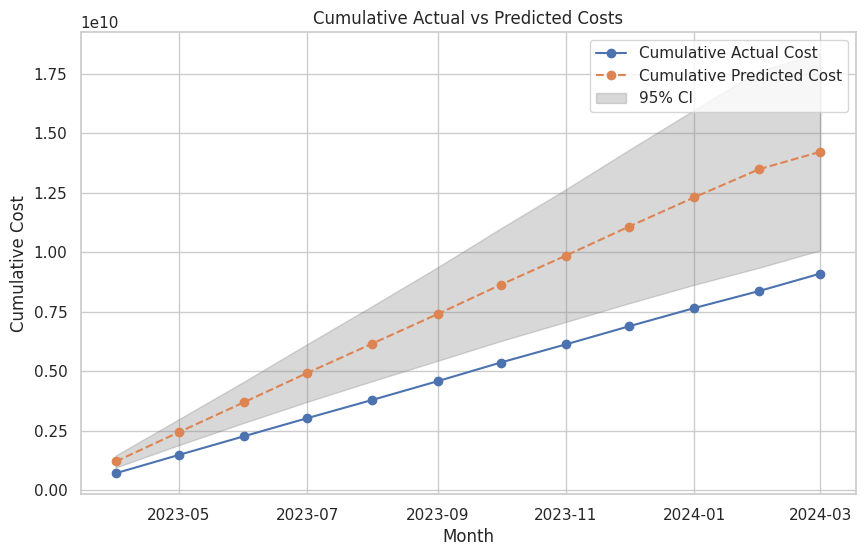

In [470]:
# Calculate cumulative sums
grouped_2324_df['cumulative_actual_cost'] = grouped_2324_df['actual_cost'].cumsum()
grouped_2324_df['cumulative_predicted_cost'] = grouped_2324_df['predicted_cost'].cumsum()
grouped_2324_df['cumulative_predicted_cost_AutoARIMA-lo-95'] = grouped_2324_df['predicted_cost_AutoARIMA-lo-95'].cumsum()
grouped_2324_df['cumulative_predicted_cost_AutoARIMA-hi-95'] = grouped_2324_df['predicted_cost_AutoARIMA-hi-95'].cumsum()

# Plotting the cumulative costs
plt.figure(figsize=(10, 6))
plt.plot(grouped_2324_df['month'], grouped_2324_df['cumulative_actual_cost'], label='Cumulative Actual Cost', marker='o')
plt.plot(grouped_2324_df['month'], grouped_2324_df['cumulative_predicted_cost'], label='Cumulative Predicted Cost', marker='o', linestyle='--')
plt.fill_between(grouped_2324_df['month'], grouped_2324_df['cumulative_predicted_cost_AutoARIMA-lo-95'], grouped_2324_df['cumulative_predicted_cost_AutoARIMA-hi-95'], color='gray', alpha=0.3, label='95% CI')
plt.xlabel('Month')
plt.ylabel('Cumulative Cost')
plt.title('Cumulative Actual vs Predicted Costs')
plt.legend()
plt.grid(True)
plt.show()

In [329]:
non_topx_rx_df.head()

,month,bnf_name,bnf_code,quantity,items,actual_cost
7,2022-08-01,Urgotul dressing 5cm x 5cm,20031600043,6589.0,613,9670.87944
10,2022-08-01,"Aciferol D3 2,200unit tablets",0906040G0CHACCP,3431.0,90,1015.13876
13,2022-08-01,Methylprednisolone acetate 40mg/1ml inj vials,1001022K0AAAAAA,4150.0,3292,13343.84698
21,2022-08-01,Hydrocortisone 0.25% / Crotamiton 10% cream,1304000V0AAAJAJ,12630.0,409,1712.41198
22,2022-08-01,Cetirizine 10mg capsules,0304010I0AAADAD,23419.0,844,9681.27631


In [330]:
topx_rx_df.head()

,month,bnf_name,bnf_code,quantity,items,actual_cost
0,2022-08-01,Levothyroxine sodium 25microgram tablets,0602010V0AABWBW,30100466.0,839826,9.304476e+05
1,2022-08-01,Canagliflozin 300mg tablets,0601023AMAAABAB,1030710.0,32271,1.260439e+06
2,2022-08-01,Epaderm cream,21220000101,17335151.0,30118,2.432452e+05
3,2022-08-01,Strivit-D3 800unit capsules,0906040G0DNAAAN,613199.0,20095,4.925483e+04
4,2022-08-01,Zerodouble gel,21220000230,11095601.0,20576,1.181166e+05


In [334]:
print(full_price_df['bnf_code'].nunique())

3871


In [387]:
def process_dmd_data_test(dmd_raw_df, start_forecast, end_forecast):
    """
    Process and rank price per unit for demand data over a specified date range.

    Parameters:
    - dmd_raw_df (pd.DataFrame): The input DataFrame with raw demand data.
    - start_forecast (str): The start date of the forecast period (format 'YYYY-MM-DD').
    - end_forecast (str): The end date of the forecast period (format 'YYYY-MM-DD').

    Returns:
    - pd.DataFrame: The processed DataFrame with monthly price per unit and rankings.
    """
    
    # Define the inner function to calculate price
    def calculate_price_new(row):
        # Check if 'priceinfo_pricedt' is NaT or if 'month' is greater than or equal to 'pricedt'
        if pd.isna(row['priceinfo_pricedt']) or row['month'] >= row['priceinfo_pricedt']:
            return row['priceinfo_price']
        else:
            return row['priceinfo_price_prev']

    # Create date range
    date_range = pd.date_range(start=start_forecast, end=end_forecast, freq='MS')
    
    # Create DataFrame based on date range
    date_range_df = pd.DataFrame(date_range, columns=['month'])
    
    # Concatenate demand data with date range
    dmd_data = pd.concat([dmd_raw_df] * len(date_range), ignore_index=True).reset_index(drop=True)
    
    # Merge date range with demand data
    dmd_price_df = pd.concat([date_range_df, dmd_data], axis=1)
    
    # Apply the price calculation function
    dmd_price_df['price_pence'] = dmd_price_df.apply(calculate_price_new, axis=1)
    
    # Calculate price per unit
    #dmd_price_df['price_per_unit'] = (dmd_price_df['price_pence'] / dmd_price_df['qtyval']).astype(float)
    
    # Rank price per unit
    #dmd_price_df['row_number'] = dmd_price_df.groupby(['month', 'bnf_code'])['price_per_unit'].rank(method='first', ascending=False)
    
    # Filter to get the top-ranked price per unit per month and BNF code
    #dmd_price_df = dmd_price_df[dmd_price_df['row_number'] == 1][['month', 'bnf_code', 'price_per_unit']]
    
    return dmd_price_df


In [389]:
test_fuck_up = process_dmd_data_test(dmd_raw_df, '2023-01-01', '2023-06-01')

In [391]:
test_fuck_up =test_fuck_up[
    (test_fuck_up['bnf_code'] == '0302000C0BQAABX')]
print(test_fuck_up)

       month               ampp         bnf_code  priceinfo_price  \
14392    NaT  12906511000001101  0302000C0BQAABX             2932   
99341    NaT  12906511000001101  0302000C0BQAABX             2932   
184290   NaT  12906511000001101  0302000C0BQAABX             2932   
269239   NaT  12906511000001101  0302000C0BQAABX             2932   
354188   NaT  12906511000001101  0302000C0BQAABX             2932   
439137   NaT  12906511000001101  0302000C0BQAABX             2932   

       priceinfo_pricedt  priceinfo_price_prev         qtyval  price_pence  
14392                NaT                  <NA>  120.000000000         2932  
99341                NaT                  <NA>  120.000000000         2932  
184290               NaT                  <NA>  120.000000000         2932  
269239               NaT                  <NA>  120.000000000         2932  
354188               NaT                  <NA>  120.000000000         2932  
439137               NaT                  <NA>  120.00

In [405]:
def process_dmd_data_test_2(dmd_raw_df, start_forecast, end_forecast):
    """
    Process and rank price per unit for demand data over a specified date range.

    Parameters:
    - dmd_raw_df (pd.DataFrame): The input DataFrame with raw demand data.
    - start_forecast (str): The start date of the forecast period (format 'YYYY-MM-DD').
    - end_forecast (str): The end date of the forecast period (format 'YYYY-MM-DD').

    Returns:
    - pd.DataFrame: The processed DataFrame with monthly price per unit and rankings.
    """
    
    # Generate the date range for the forecast period
    date_range = pd.date_range(start=start_forecast, end=end_forecast, freq='MS')
    
    # Create a DataFrame with the date range
    date_range_df = pd.DataFrame(date_range, columns=['month'])
    
    # Add a key to perform a cross join
    date_range_df['key'] = 1
    dmd_raw_df['key'] = 1
    
    # Perform a cross join
    combined_df = pd.merge(date_range_df, dmd_raw_df, on='key').drop('key', axis=1)
    
    # Ensure 'priceinfo_pricedt' is in datetime format
    combined_df['priceinfo_pricedt'] = pd.to_datetime(combined_df['priceinfo_pricedt'])
    
    # Sort by 'bnf_code' and 'month' to prepare for forward fill
    combined_df.sort_values(by=['bnf_code', 'month'], inplace=True)
    
    # Forward fill price information
    combined_df['priceinfo_price'] = combined_df.groupby('bnf_code')['priceinfo_price'].ffill()
    combined_df['priceinfo_price_prev'] = combined_df.groupby('bnf_code')['priceinfo_price_prev'].ffill()
    
    # Calculate the correct price based on the conditions
    combined_df['price_pence'] = combined_df.apply(
        lambda row: row['priceinfo_price'] if pd.isna(row['priceinfo_pricedt']) or row['month'] >= row['priceinfo_pricedt']
        else row['priceinfo_price_prev'], axis=1
    )


    # Calculate price per unit
    combined_df['price_per_unit'] = combined_df['price_pence'] / combined_df['qtyval']
    
    # Rank price per unit
    combined_df['row_number'] = combined_df.groupby(['month', 'bnf_code'])['price_per_unit'].rank(method='first', ascending=False)
    
    # Filter to get the top-ranked price per unit per month and BNF code
    result_df = combined_df[combined_df['row_number'] == 1][['month', 'bnf_code', 'price_per_unit']]

    return result_df

In [443]:
test_fuck_up_2 = process_dmd_data(dmd_raw_df, '2023-04-01', '2024-03-01')

In [444]:
test_fuck_up_2 =test_fuck_up_2[
    (test_fuck_up_2['bnf_code'] == '0302000C0BQAABX')]
print(test_fuck_up_2)

            month         bnf_code                 price_per_unit
14392  2023-04-01  0302000C0BQAABX  24.43333333333333333333333333
99341  2023-05-01  0302000C0BQAABX  24.43333333333333333333333333
184290 2023-06-01  0302000C0BQAABX  24.43333333333333333333333333
269239 2023-07-01  0302000C0BQAABX  24.43333333333333333333333333
354188 2023-08-01  0302000C0BQAABX  24.43333333333333333333333333
439137 2023-09-01  0302000C0BQAABX  24.43333333333333333333333333
524086 2023-10-01  0302000C0BQAABX  24.43333333333333333333333333
609035 2023-11-01  0302000C0BQAABX  24.43333333333333333333333333
693984 2023-12-01  0302000C0BQAABX  24.43333333333333333333333333
778933 2024-01-01  0302000C0BQAABX  24.43333333333333333333333333
863882 2024-02-01  0302000C0BQAABX  24.43333333333333333333333333
948831 2024-03-01  0302000C0BQAABX  24.43333333333333333333333333
